In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
# Path to the data folder where "download_data_temperature.py" downloaded the data and
# it was unzipped
data_path = Path("/mnt/d/pictures/")  

In [3]:
temp = xr.open_dataset(data_path / "download.nc")

In [4]:
temp

<xarray.Dataset>
Dimensions:     (time: 1005, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2023-09-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] ...
Data variables:
    t2m         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-11-17T12:46 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
# Cities and position from Wikipedia https://en.wikipedia.org/wiki/Global_city
coords = {
    "New York City": [40.712778, -74.005833],
    "London": [51.50939, -0.11832],
    "Paris": [48.856667, 2.351667],
    "Bejing": [39.933333, 116.383333],
    "Dubai": [25.266667, 55.3],
    "Hong Kong": [22.3, 114.166667],
    "Shanghai": [31.233333, 121.466667],
    "Singapore": [1.283333, 103.833333],
    "Tokyo": [35.683889, 139.774444],
}
city_names = list(coords.keys())
city_lats = np.array(list(coords.values()))[:, 0]
city_longs = np.array(list(coords.values()))[:, 1]
# Round coordinates to 0.25 degrees.
city_lats = 0.25 * np.round(city_lats / 0.25)
city_longs = 0.25 * np.round(city_longs / 0.25)
city_longs %= 360  # for plotting purposes
cities = xr.DataArray(
    data=city_names,
    dims=["city"],
    coords={"latitude": ("city", city_lats), "longitude": ("city", city_longs)},
)

In [6]:
cities

<xarray.DataArray (city: 9)>
array(['New York City', 'London', 'Paris', 'Bejing', 'Dubai', 'Hong Kong',
       'Shanghai', 'Singapore', 'Tokyo'], dtype='<U13')
Coordinates:
    latitude   (city) float64 40.75 51.5 48.75 40.0 25.25 22.25 31.25 1.25 35.75
    longitude  (city) float64 286.0 0.0 2.25 116.5 55.25 114.2 121.5 103.8 139.8
Dimensions without coordinates: city

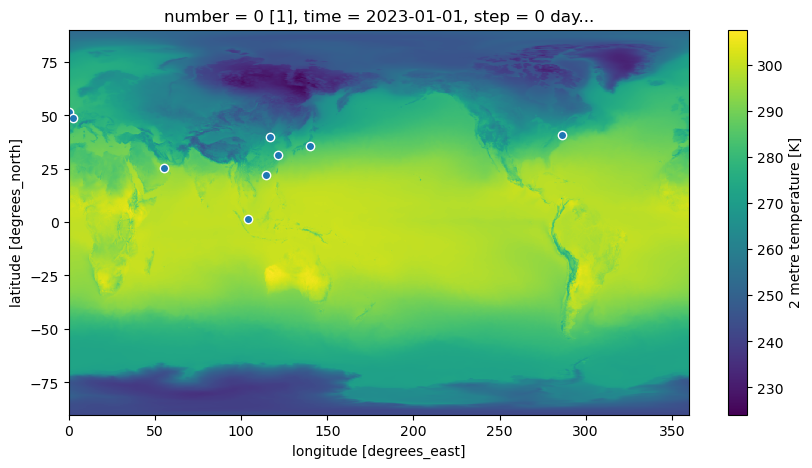

In [7]:
# Check if the positions are correct
plt.figure(figsize=(10, 5))
temp["t2m"].sel(time="2023-01-01").plot()
plt.scatter(cities.longitude, cities.latitude, edgecolors="w")

In [8]:
# Compute correction factor for Earth geometry from latitudes
weight = np.cos(np.deg2rad(temp.latitude))

In [9]:
global_file_name = "global_monthly_temp.nc"
city_file_name = "city_monthly_temp.nc"

In [10]:
if not Path(data_path / global_file_name).exists():
    global_monthly_temp = xr.DataArray(
        np.zeros(len(temp.time.values)),
        dims=["time"],
        coords={"time": temp.time.values},
    )

    step = 10
    start = 1940
    end = 2023
    for i in range(start, end, step):
        print(i + step)
        global_monthly_temp.loc[dict(time=slice(str(i), str(i + step)))] = (
            temp["t2m"]
            .sel(time=slice(str(i), str(i + step)))
            .weighted(weight)
            .mean(dim=["latitude", "longitude"])
            .values
        )
    global_monthly_temp.to_netcdf(data_path / global_file_name)
else:
    global_monthly_temp = xr.open_dataarray(data_path / global_file_name)

if not Path(data_path / city_file_name).exists():
    city_monthly_temp = xr.DataArray(
        np.zeros(len(temp.time.values)),
        dims=["time"],
        coords={"time": temp.time.values},
    )
    city_temp = temp["t2m"].sel(
        latitude=cities.latitude,
        longitude=cities.longitude,
    ).mean(dim=["city"])
    step = 10
    start = 1940
    end = 2023
    for i in range(start, end, step):
        print(i + step)
        city_monthly_temp.loc[dict(time=slice(str(i), str(i + step)))] = city_temp.sel(
            time=slice(str(i), str(i + step)),
        ).values
    city_monthly_temp.to_netcdf(data_path / city_file_name)
else:
    city_monthly_temp = xr.open_dataarray(data_path / city_file_name)

In [11]:
# Compute the anomaly relative to the 1981-2010 mean
global_yearly_temp = global_monthly_temp.groupby("time.year").mean()
mean_ref = global_yearly_temp.sel(year=slice("1981", "2010")).mean()

city_yearly_temp = city_monthly_temp.groupby("time.year").mean()
city_mean_ref = city_yearly_temp.sel(year=slice("1981", "2010")).mean()

In [12]:
# ERA5 bias correction to pre-industrial temperature is discussed in:
#   https://climate.copernicus.eu/surface-temperature
start = "1981"
end = "2023"
anomaly = (global_yearly_temp - mean_ref + 0.63).sel(year=slice(start, end))
anomaly_city = (city_yearly_temp - city_mean_ref + 0.63).sel(year=slice(start, end))

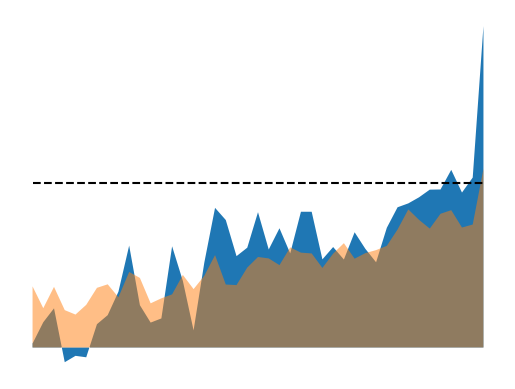

In [13]:
ymin = 0
plt.fill_between(
    anomaly_city.year.values,
    ymin,
    anomaly_city.values,
    alpha=1,
)
plt.fill_between(
    anomaly.year.values,
    ymin,
    anomaly.values,
    alpha=0.5,
)
xlim = anomaly.year.values.min(), anomaly.year.values.max()
plt.hlines(1.5, *xlim, linestyles="dashed")
plt.gca().set_axis_off()
plt.savefig("global_and_cities.svg")